# Ajuste-fino da Arquitetura do Modelo e Hiperparâmetros RP

Com o estudo anterior (17), consolidamos a melhor `Taxa de Amostragem (= 5)` e o melhor `Tamanho de Janela` para cada aparelho da `residência 3` na base REDD.

Apesar de resultados satisfatórios, o processo de otimização considerou um pipeline canônico, escolhido aleatoriamente, composto de:
* Um conversor de séries em imagens baseado em Gráfico de Recorrência;
* Um modelo classificador baseado em CNN.

Neste sentido, a adoção de uma estratégia sistemática para escolha da arquitetura do modelo classificador e explotar diferentes combinações de hiperparâmetros do Gráfico de recorrência tendem a culminar em resultados de ponta para a identificação de cargas.

Portanto, neste estudo temos os seguintes objetivos:
1. Construir um modelo baseado em Deep Learning utilizando um arcabouço sistemático;
2. Varrer um conjunto discreto de valores combinatórios dos hiperparâmetros do RP.

# Configurações

In [2]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

In [3]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "18") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")

# Path completo do arquivo REDD
arquivo_dataset = os.path.join(caminho_redd, "redd.h5")

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_redd, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

# Dados

## Base REDD

In [4]:
# Exemplo de carregamento da base REDD no NILMTK
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.dataset_converters import convert_redd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from PyNILM.dados.janelas import Janelas

# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset):
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)
print()

# Parametros dos dados
PARAMETROS_DATASET = {
    "base":redd,
    "id_residencia":3,
    "inicio_intervalo":'2011-04-16 05:11:30',
    "fim_intervalo":'2011-04-23 08:43:26',
    "debug": False    
}
print("PARÂMETROS DO ESTUDO:")
pprint(PARAMETROS_DATASET)

NILMTK -> Detalhes sobre o dataset REDD:



PARÂMETROS DO ESTUDO:
{'base': <nilmtk.dataset.DataSet object at 0x000002348CC2F0B8>,
 'debug': False,
 'fim_intervalo': '2011-04-23 08:43:26',
 'id_residencia': 3,
 'inicio_intervalo': '2011-04-16 05:11:30'}


## Melhores Janelas para cada aparelho (estudo 17)

In [5]:
df_melhores_janelas = pd.read_csv(os.path.join(caminho_dados, "17", "taxa_5-melhoresjanelas.csv"))
df_melhores_janelas

,taxa_amostragem,carga,janela,loss,acuracia,f1_macro
0,5,sockets - 3,1080,0.103,93.10,73.15
1,5,sockets - 4,30,0.000,100.00,100.00
2,5,light - 5,1080,0.018,100.00,100.00
3,5,ce_appliance - 6,360,0.000,100.00,100.00
4,5,fridge - 7,360,0.000,100.00,100.00
5,5,waste_disposal_unit - 8,30,0.099,99.81,49.95
6,5,dish_washer - 9,60,0.092,97.67,74.40
7,5,electric_furnace - 10,30,1.154,90.70,82.94
8,5,light - 11,30,7.155,82.76,79.20
9,5,sockets - 12,30,2.086,85.96,67.43


# Construção da Arquitetura do Modelo de DL
---

Nesta etapa, iremos considerar apenas um aparelho a fim de direcionar os esforços de modo eficiente. Sendo assim, iremos escolher o aparelho com base em dois parâmetros: 1) os que mais consomem energia na medição histórica (dentre as cinco do paper IEEE); e 2) que possui maior equilíbrio nas amostras (visando avaliação mais justa).

In [6]:
# from PyNILM.dados.janelas import Janelas

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from sklearn.model_selection import train_test_split

from pyts.image import RecurrencePlot

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPool1D
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


from pyts.image import RecurrencePlot, GramianAngularField

# Garantindo reprodutibilidade
import random as rn
# Constantes dos experimentos
SEED = 33
FRACAO_TESTE = 0.25
EPOCAS = 100
TAMANHO_LOTE = 32
VERBOSIDADE = 0
PARAMETROS_RP = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
TAMANHO_IMAGEM = (32,32)
# PARAMETROS_RP={
#     "dimension": 3,
#     "time_delay": 8,
#     "threshold": 0.1
# }
# Travar Seed's
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# Habilitando/limitando utilização de GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*0.5)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("# GPUs habilitadas:", "{} física(s)".format(len(gpus)), "/", "{} lógica(s)".format(len(gpus)))
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# GPUs habilitadas: 1 física(s) / 1 lógica(s)


## Selecionando os dados de um dos aparelhos

In [7]:
# Escolhendo aparelho (conforme enunciado)
# -------------------

# Intervalo de tempo e residencia considerados na base REDD
janelas = Janelas(**PARAMETROS_DATASET)

# 1) Para cada aparelho dos considerados no paper IEE GM
for i, r in df_melhores_janelas.loc[
    (df_melhores_janelas["carga"].isin([
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ])), :
].iterrows():
    
    # Informacoes da carga (nome, id, taxa e janela)
    carga = r["carga"].split(" - ")[0]
    instancia = int(r["carga"].split(" - ")[1])
    taxa = r["taxa_amostragem"]
    janela = r["janela"]
    print(f"* `{r['carga'].upper()}` / taxa={taxa} e janela={janela} / f1={r['f1_macro']}...")
          
    # 2) Carregar dados e verificar distribuição DA CARGA / JANELA
    
    # Extrair series divididas em janelas para cada medidor
    dados_cargas = janelas.preparar(taxa_amostral=taxa, intervalo_medicao=janela)
    print()
    
    # Escolhendo apenas dados do aparelho
    dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, carga)])
    # Analise dos dados
    distribuicao = dict(Counter(dados_aparelho[0]["rotulos"]["estado"]))
    maioritaria = max(distribuicao, key=distribuicao.get)
    minoritaria = 1 - maioritaria
    print(
        "  -> Distribuição:", distribuicao, 
        "(índice de equilíbrio = {:.2f}%)".format(
            (distribuicao[minoritaria]/distribuicao[maioritaria])*100
        )
    )

    print()

* `FRIDGE - 7` / taxa=5 e janela=360 / f1=100.0...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {1: 266, 0: 77} (índice de equilíbrio = 28.95%)

* `DISH_WASHER - 9` / taxa=5 e janela=60 / f1=74.4...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 2031, 1: 27} (índice de equilíbrio = 1.33%)

* `WASHER_DRYER - 13` / taxa=5 e janela=60 / f1=92.11...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 2011, 1: 47} (índice de equilíbrio = 2.34%)

* `WASHER_DRYER - 14` / taxa=5 e janela=30 / f1=82.88...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 3988, 

**NOTA:** será selecionado o aparelho `MICROWAVE - 16`, dado que este é o que possui o menor desempenho considerando o f1-score (macro).

## Preparando os dados do aparelho selecionado 

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


   - Preparando dataset/tf.data...
-----


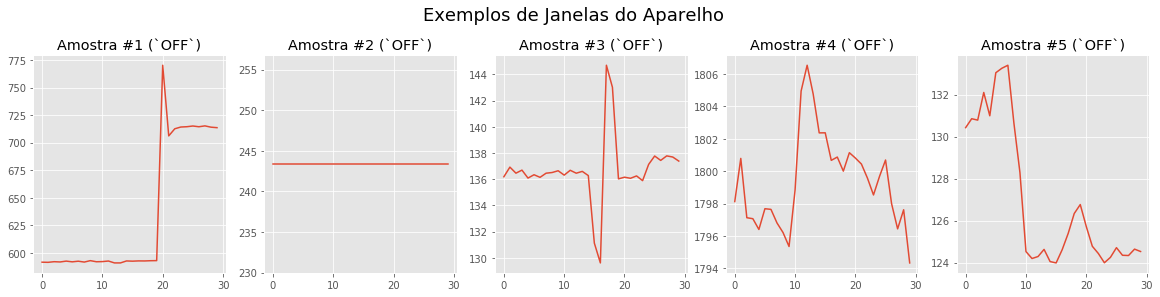

In [8]:
# Constantes referente aos dados da carga selecionada
TAXA = 5
TAMANHO_JANELA = 30

# Extrair series divididas em janelas para cada medidor
dados_cargas = janelas.preparar(
    taxa_amostral=TAXA, 
    intervalo_medicao=TAMANHO_JANELA
)
print()

# X
dados_medidores = janelas.filtrar_cargas(
    dados_cargas,
    filtros=[
        (1, 'site_meter'),
        (2, 'site_meter'),    
    ]
)
# y
dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, carga)])[0]

# Fazendo split dos dados (treino/teste)
X_treino, X_teste, y_treino, y_teste = train_test_split(
    dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"], 
    dados_aparelho["rotulos"]["estado"],
    test_size=FRACAO_TESTE,
    stratify=dados_aparelho["rotulos"]["estado"],
    random_state=SEED
)
print()

# Construindo datasets (treino e teste)
print("   - Preparando dataset/tf.data...")
print("-----")
# pipelines instanciados (sem preprocessamento)
dataset_treino = tf.data.Dataset.from_tensor_slices((X_treino, y_treino))
dataset_teste = tf.data.Dataset.from_tensor_slices((X_teste, y_teste))

# Exibindo algumas amostras de janealas
num_amostras = 5
fig, axes = plt.subplots(1, num_amostras, figsize=(20,4))
estados = {1: "ON", 0: "OFF"}
for i,amostra in enumerate(dataset_treino.shuffle(33).take(num_amostras)):
    serie = amostra[0].numpy()
    estado = amostra[1].numpy()
    axes[i].plot(np.arange(0, serie.shape[0]), serie)
    axes[i].set_title(f"Amostra #{i+1} (`{estados[estado]}`)")
plt.suptitle("Exemplos de Janelas do Aparelho", size=18, y=1.05)
plt.show()

# del X_treino
# del y_treino
# del X_teste
# del y_teste
del dados_cargas
del dados_medidores
del dados_aparelho

# # Pipelines consolidados com pré-processamento das imagens
# dataset_treino = dataset_treino.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))
# dataset_teste = dataset_teste.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))

**NOTA:** Interessante observar que amostras rotuladas como `OFF` mesmo possuindo alguma curva no gráfico ou variação maior que 0. Isto ocorre pois tais sinais são tratados como ruído pela biblioteca NILMTK (conforme a baixa amplitude da medição), base do pré-processamento da PyNILM. Logo, é observado que os dados foram tratados corretamente.

In [11]:
# Construindo o pipeline de dados
# ----------

import cv2

# Constante fundamentais
TAMANHO_IMAGEM = (32,32,1) # Apenas 1 canal
TIPO_DADOS = np.float32
def serie_para_imagem(serie, params_rp = PARAMETROS_RP, tam_imagem=TAMANHO_IMAGEM):
    """
    Funcao responsavel por gerar e tratar a imagem RP.
    """
    # Gerando imagem RP/redimensionando
    imagem = RecurrencePlot(**params_rp).fit_transform([serie])[0]
    imagem = cv2.resize(
            imagem, 
            dsize=tam_imagem[:2], 
            interpolation=cv2.INTER_CUBIC
        ).astype(TIPO_DADOS)
    # Normalizar
    #imagem = (imagem - imagem.min()) / (imagem.max() - imagem.min()) # MinMax (0,1)
    imagem = (imagem - imagem.mean()) / imagem.mean() # Std
    # N canais
    imagem = np.stack([imagem for i in range(tam_imagem[-1])],axis=-1)
    return imagem

def preparar_amostra(amostra, rotulo):
    """
    Preparação da amostra/rótulo para o modelo.
    """
    # Convertendo serie para imagem
    amostra = tf.numpy_function(serie_para_imagem, [amostra], TIPO_DADOS)
    amostra = tf.reshape(amostra, TAMANHO_IMAGEM)
    return amostra, rotulo

# pipelines consolidados
dataset_treino = dataset_treino.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))
dataset_teste = dataset_teste.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))

# # Efeito do sacling
#i = 1
# for amostra in dataset_treino:
#     imagem = amostra[0].numpy()
#     #imagem_ = (imagem - imagem.mean()) / imagem.std() # STD sacaling
#     imagem_ = (imagem - imagem.min()) / (imagem.max() - imagem.min()) # MinMax (0,1)

#     fig, axes = plt.subplots(1,2, figsize=(6,6))
#     axes[0].imshow(imagem[:,:,0], origin="lower")
#     axes[0].set_title("Original (Min:{:.2f} / Max:{:.2f})".format(imagem.min(),imagem.max()), size=10)
#     axes[0].grid(False)

#     axes[1].imshow(imagem_[:,:,0], origin="lower")
#     axes[1].set_title("Scaled (Min:{:.2f} / Max:{:.2f})".format(imagem_.min(),imagem_.max()), size=10)
#     axes[1].grid(False)
#     plt.suptitle(f"Amostra #{i}", size=14, y=0.75)
#     plt.show()
    
#     i+=1
#     if i>=10:
#         break

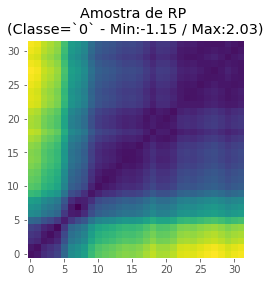

In [12]:
# Exemplo de amostra processada no pipeline
for a in dataset_treino.shuffle(SEED).batch(1).take(1):
    rp = a[0][0].numpy()
    plt.imshow(rp[:,:,0], origin="lower")
    plt.grid(False)
    plt.title("Amostra de RP \n(Classe=`{}` - Min:{:.2f} / Max:{:.2f})".format(
        a[1][0].numpy(),
        rp.min(),
        rp.max()
    ))
    break

## Construindo o modelo

### Buscando o Overfitting

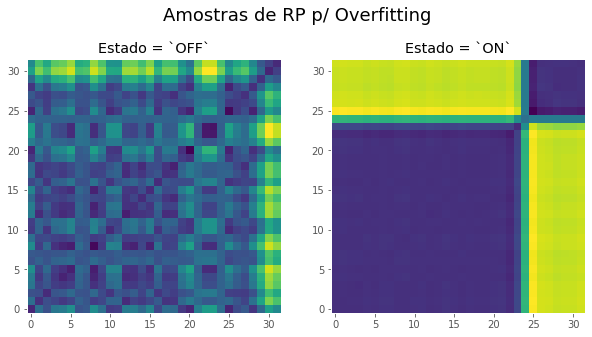

In [14]:
X,y = [], []

for amostra in dataset_treino.shuffle(SEED):
    imagem = amostra[0].numpy()
    rotulo = amostra[1].numpy()
    # Verificar se N possui amostra da classe
    if y.count(rotulo) == 0:
        X.append(imagem)
        y.append(rotulo)
    
    # Verificar se ja possui condicao de parada (1 de cada classe)
    if np.unique(y).shape[0] == 2:
        break
        
# Amostras selecionadas
fig, axes  = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(X[0][:,:,0], origin="lower")
axes[0].set_title(f"Estado = `{estados[y[0]]}`")
axes[0].grid(False)
axes[1].imshow(X[1][:,:,0], origin="lower")
axes[1].set_title(f"Estado = `{estados[y[1]]}`")
axes[1].grid(False)
plt.suptitle("Amostras de RP p/ Overfitting", size=18, y=1.0);

In [9]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, \
                    Dropout, MaxPool2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.constraints import max_norm
from sklearn.utils import class_weight

def convnet(
    loss_function = 'binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy'],
    bias_output = 0,
):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(32,32,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1, activation="sigmoid",
                    bias_initializer=tf.keras.initializers.Constant(bias_output), 
                    name="output"))

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
    
    return model

def modelo_baseline(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'], 
    bias_output = 0,
    name="Baseline"
):
    tf.random.set_seed(SEED)
    
    model = Sequential(name=name)

    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="valid", kernel_initializer = 'he_uniform', input_shape=(32,32,1), kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    model.add(AveragePooling2D())
    #model.add(MaxPool2D())
    
    model.add(Conv2D(128, kernel_size=(3,3), padding="valid", kernel_initializer = 'he_uniform', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    model.add(AveragePooling2D())
    #model.add(MaxPool2D())
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))

    model.add(Dense(128))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    #model.add(Dropout(0.2))
 
    # Output
    model.add(Dense(1, activation='sigmoid', 
                    bias_initializer=tf.keras.initializers.Constant(bias_output), 
                    name="output"))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model


def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.

      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)

      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.

    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)

    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
               -K.mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

    return binary_focal_loss_fixed


def modelo_baseline2(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'], 
    bias_output = 0,
    name="Baseline"
):
    tf.random.set_seed(SEED)
    
    model = Sequential(name=name)

    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="valid", kernel_initializer = 'he_uniform', input_shape=(32,32,1), kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    model.add(AveragePooling2D())
    #model.add(MaxPool2D())
    
    model.add(Conv2D(128, kernel_size=(3,3), padding="valid", kernel_initializer = 'he_uniform', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    model.add(AveragePooling2D())
    #model.add(MaxPool2D())
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))

    model.add(Dense(128))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    #model.add(Dropout(0.2))
 
    # Output
    model.add(Dense(1, activation='sigmoid', 
                    bias_initializer=tf.keras.initializers.Constant(bias_output), 
                    name="output"))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

# # from PyNILM.dados.janelas import Janelas

# from PyNILM.avaliacao.metricas import *
# from PyNILM.avaliacao.graficos import *
# from PyNILM.avaliacao.analises import *

# from sklearn.model_selection import train_test_split

# from pyts.image import RecurrencePlot
# import cv2

# import tensorflow as tf
# # from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPool1D
# # from tensorflow.keras.utils import to_categorical
# # from tensorflow.keras import backend as K
# # from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


# from pyts.image import RecurrencePlot, GramianAngularField

        


In [16]:
# Erro esperado
n_classes = 2
print("* Erro esperado:", -np.log(1/n_classes))
print()

# calculando punicao para classes (desbalanceamento)
dist_treino = [amostra[1].numpy().astype(np.int16) for amostra in dataset_treino]
pesos_classes = class_weight.compute_class_weight('balanced',np.unique(dist_treino),dist_treino)
pesos_classes = {0: pesos_classes[0], 1: pesos_classes[1]}
print("* Punição de classes:", pesos_classes)
print()

# Inicializacao do output em compasso com distribuicao dos dados
distribuicao_treino = Counter(y_treino)
classe_minoritaria = min(distribuicao_treino, key=distribuicao_treino.get)
classe_majoritaria = max(distribuicao_treino, key=distribuicao_treino.get)
razao_min_maj  = np.float16(distribuicao_treino[classe_majoritaria]/distribuicao_treino[classe_minoritaria])
bias_inicial_output = np.log([distribuicao_treino[1]/distribuicao_treino[0]])
print("* Distribuição treino:", distribuicao_treino)
print("--- Classe minoritária :", classe_minoritaria)
print("--- Classe majoritaria :", classe_majoritaria)
print("--- Razão entre min/maj = {}:{}".format(1, razao_min_maj))
print("--- Bias inicial output =", bias_inicial_output)
print()

# Instanciando modelo
modelo_overfitting = modelo_baseline(
    optimizer=tf.keras.optimizers.RMSprop(1e-3, momentum=0.5),
    bias_output=bias_inicial_output
)
print("* Detalhes do modelo:")
print("---")
print(modelo_overfitting.summary())
print()

* Erro esperado: 0.6931471805599453

* Punição de classes: {0: 0.5055682934818212, 1: 45.39705882352941}

* Distribuição treino: Counter({0: 3053, 1: 34})
--- Classe minoritária : 1
--- Classe majoritaria : 0
--- Razão entre min/maj = 1:89.8125
--- Bias inicial output = [-4.49751947]

* Detalhes do modelo:
---
Model: "Baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 64)        640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (

In [17]:
print("* Treinando:")
print("---")
historico = modelo_overfitting.fit(
    np.asarray(X).astype(TIPO_DADOS), np.array(y),
    #class_weight=pesos_classes,
    epochs=10,
    verbose=2    
)

* Treinando:
---
Epoch 1/10
1/1 - 0s - loss: 3.0258 - accuracy: 0.5000
Epoch 2/10
1/1 - 0s - loss: 3.2439 - accuracy: 0.5000
Epoch 3/10
1/1 - 0s - loss: 5.0412 - accuracy: 0.5000
Epoch 4/10
1/1 - 0s - loss: 0.1590 - accuracy: 1.0000
Epoch 5/10
1/1 - 0s - loss: 0.0188 - accuracy: 1.0000
Epoch 6/10
1/1 - 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 7/10
1/1 - 0s - loss: 6.8061e-04 - accuracy: 1.0000
Epoch 8/10
1/1 - 0s - loss: 4.2267e-04 - accuracy: 1.0000
Epoch 9/10
1/1 - 0s - loss: 3.0368e-04 - accuracy: 1.0000
Epoch 10/10
1/1 - 0s - loss: 2.3934e-04 - accuracy: 1.0000


**NOTA:** O modelo é capaz de aprender os padrões dos dados.

### Ajustando hiperparâmetros no conjunto completo


Seguindo as premissas exibidas em [Deep Learning Recipe](http://karpathy.github.io/2019/04/25/recipe/)

In [13]:
# Pré-processamento das entradas
print("* Preparando dados (treino/teste)...")
print("---")

# Constantes referente aos dados da carga selecionada
TAXA = 5
TAMANHO_JANELA = 30

# Extrair series divididas em janelas para cada medidor
dados_cargas = janelas.preparar(
    taxa_amostral=TAXA, 
    intervalo_medicao=TAMANHO_JANELA
)
print()

# Entrada
dados_medidores = janelas.filtrar_cargas(
    dados_cargas,
    filtros=[
        (1, 'site_meter'),
        (2, 'site_meter'),    
    ]
)
X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]
X_imagem = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)
X_imagem = np.stack([
    [cv2.resize(
        imagem, 
        dsize=TAMANHO_IMAGEM[:-1], 
        interpolation=cv2.INTER_CUBIC).astype(np.float16) \
        for imagem in tqdm_notebook(X_imagem)]
], axis=-1).astype(np.float16) 

# rotulos
dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, carga)])[0]
y = dados_aparelho["rotulos"]["estado"]

del dados_medidores
del dados_aparelho
gc.collect()

# Fazendo split dos dados (treino/teste)
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X_imagem, y,
    test_size=FRACAO_TESTE,
    stratify=y if np.unique(y).shape[0] > 1 else None, # Ver viabilidade estratificacao
    random_state=SEED
)

del X
del y
gc.collect()

# from imblearn.over_sampling import RandomOverSampler
# X_treino, y_treino = RandomOverSampler(random_state=SEED).fit_resample(
#     X_treino.reshape(-1, np.product((32,32,1))), 
#     y_treino
# )
# X_treino = X_treino.reshape(-1, 32,32,1)

# # Convertendo series em imagens
# X_treino_imagens = np.stack([serie_para_imagem(x,params_rp=PARAMETROS_RP) for x in X_treino])
# X_teste_imagens = np.stack([serie_para_imagem(x,params_rp=PARAMETROS_RP) for x in X_teste])
print()

print("* Carregando parametros da arquitetura...")
print("---")

# Inicializacao do output em compasso com distribuicao dos dados
distribuicao_treino = Counter(y_treino)
classe_minoritaria = min(distribuicao_treino, key=distribuicao_treino.get)
classe_majoritaria = max(distribuicao_treino, key=distribuicao_treino.get)
razao_min_maj  = np.float16(distribuicao_treino[classe_majoritaria]/distribuicao_treino[classe_minoritaria])
bias_inicial_output = np.log([distribuicao_treino[1]/distribuicao_treino[0]])
print("   -> Distribuição treino:", distribuicao_treino)
print("      --- Classe minoritária :", classe_minoritaria)
print("      --- Classe majoritaria :", classe_majoritaria)
print("      --- Razão entre min/maj = {}:{}".format(1, razao_min_maj))
print("      --- Bias inicial output =", bias_inicial_output)
print()


# calculando punicao para classes (desbalanceamento)
dist_treino = [y for y in y_treino]
pesos_classes = class_weight.compute_class_weight('balanced',np.unique(dist_treino),dist_treino)
pesos_classes = {0: pesos_classes[0], 1: pesos_classes[1]}
print("   -> Punição de classes:", pesos_classes)
print()

print("* Treinando modelo:")
print("---")

# Instanciando o modelo
# modelo = modelo_baseline(
#     optimizer=tf.keras.optimizers.Adam(1e-5),#RMSprop(1e-7, momentum=0.5),#,#
#     #optimizer=tf.keras.optimizers.RMSprop(lr=1e-2, decay=0.01),
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     #loss=binary_focal_loss(),
#     bias_output=bias_inicial_output
# )
# #print(modelo.summary())
def convnet2(
    loss_function = 'binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy'],
    bias_output = 0,
):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_uniform', input_shape=(32,32,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))
    
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation='relu', kernel_initializer = 'he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer = 'he_uniform'))
    #model.add(Dropout(0.5))

    model.add(Dense(1, activation="sigmoid",
                    bias_initializer=tf.keras.initializers.Constant(bias_output), 
                    name="output"))

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
    
    return model
modelo = convnet2()

historico = modelo.fit(
    x=X_treino, y=y_treino,
    validation_data=(X_teste, y_teste),
    batch_size=TAMANHO_LOTE,
    #class_weight=pesos_classes,
    epochs=EPOCAS,
    callbacks=[
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=20)
    ],
    verbose=2    
)
print()

print("* Avaliando modelo/hipótese no conjunto de teste...")
print("---")
y_pred = modelo.predict(X_teste).round().astype(np.int16)
print()
print(classification_report(y_teste, y_pred))#, labels=("OFF", "ON")))
print(confusion_matrix(y_teste, y_pred))#, labels=("OFF", "ON")))

tf.keras.backend.clear_session()

# del X_treino
# del y_treino
# del X_teste
# del y_teste
# gc.collect()

* Preparando dados (treino/teste)...
---
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.




* Carregando parametros da arquitetura...
---
   -> Distribuição treino: Counter({0: 3053, 1: 34})
      --- Classe minoritária : 1
      --- Classe majoritaria : 0
      --- Razão entre min/maj = 1:89.8125
      --- Bias inicial output = [-4.49751947]

   -> Punição de classes: {0: 0.5055682934818212, 1: 45.39705882352941}

* Treinando modelo:
---
Epoch 1/100
97/97 - 1s - loss: 42.0836 - accuracy: 0.8908 - val_loss: 4.8356 - val_accuracy: 0.8698
Epoch 2/100
97/97 - 0s - loss: 1.8032 - accuracy: 0.9508 - val_loss: 1.8357 - val_accuracy: 0.9582
Epoch 3/100
97/97 - 0s - loss: 1.0074 - accuracy: 0.9647 - val_loss: 1.7996 - val_accuracy: 0.9874
Epoch 4/100
97/97 - 0s - loss: 0.5463 - accuracy: 0.9773 - val_loss: 2.4462 - val_accuracy: 0.9466
Epoch 5/100
97/97 - 0s - loss: 0.5421 - accuracy: 0.9861 - val_loss: 1.0963 - val_accuracy: 0.9689
Epoch 6/100
97/97 - 0s - loss: 0.2140 - accuracy: 0.9838 - val_loss: 1.5824 - val_accuracy: 0.9670
Epoch 7/100
97/97 - 0s - loss: 0.2598 - accuracy: 0.9

Epoch 80/100
97/97 - 0s - loss: 0.0310 - accuracy: 0.9932 - val_loss: 0.5560 - val_accuracy: 0.9854
Epoch 81/100
97/97 - 1s - loss: 0.0312 - accuracy: 0.9925 - val_loss: 0.5867 - val_accuracy: 0.9864
Epoch 82/100
97/97 - 1s - loss: 0.0306 - accuracy: 0.9935 - val_loss: 0.6011 - val_accuracy: 0.9864
Epoch 83/100
97/97 - 1s - loss: 0.0305 - accuracy: 0.9935 - val_loss: 0.5931 - val_accuracy: 0.9864
Epoch 84/100
97/97 - 1s - loss: 0.0302 - accuracy: 0.9935 - val_loss: 0.6084 - val_accuracy: 0.9854
Epoch 85/100
97/97 - 1s - loss: 0.0303 - accuracy: 0.9938 - val_loss: 0.6141 - val_accuracy: 0.9854
Epoch 86/100
97/97 - 1s - loss: 0.0299 - accuracy: 0.9938 - val_loss: 0.6326 - val_accuracy: 0.9864
Epoch 87/100
97/97 - 0s - loss: 0.0298 - accuracy: 0.9938 - val_loss: 0.6357 - val_accuracy: 0.9864
Epoch 88/100
97/97 - 1s - loss: 0.0297 - accuracy: 0.9938 - val_loss: 0.6408 - val_accuracy: 0.9864
Epoch 89/100
97/97 - 0s - loss: 0.0312 - accuracy: 0.9935 - val_loss: 0.6522 - val_accuracy: 0.9864


In [14]:
import autokeras as ak

# Initialize the image classifier.
print("* Treinando AutoML...")
print("---")
clf = ak.ImageClassifier(max_trials=100, seed=SEED)
clf.fit(X_treino, np.array(y_treino), epochs=100, verbose=2)

# Predict with the best model.
print("* Avaliando modelo/hipótese no conjunto de teste...")
print("---")
y_pred = clf.predict(X_teste).round().astype(np.int16)
print()
print(classification_report(y_teste, y_pred))#, labels=("OFF", "ON")))
print(confusion_matrix(y_teste, y_pred))#, labels=("OFF", "ON")))

* Treinando AutoML...
---
Epoch 1/100
78/78 - 1s - loss: 5.0106 - accuracy: 0.9579 - val_loss: 1.0724 - val_accuracy: 0.9915
Epoch 2/100
78/78 - 1s - loss: 0.5286 - accuracy: 0.9708 - val_loss: 0.1619 - val_accuracy: 0.9882
Epoch 3/100
78/78 - 1s - loss: 0.2631 - accuracy: 0.9752 - val_loss: 0.1589 - val_accuracy: 0.9763
Epoch 4/100
78/78 - 1s - loss: 0.1626 - accuracy: 0.9836 - val_loss: 0.1637 - val_accuracy: 0.9831
Epoch 5/100
78/78 - 1s - loss: 0.1350 - accuracy: 0.9876 - val_loss: 0.1914 - val_accuracy: 0.9831
Epoch 6/100
78/78 - 1s - loss: 0.0898 - accuracy: 0.9864 - val_loss: 0.1215 - val_accuracy: 0.9865
Epoch 7/100
78/78 - 1s - loss: 0.0801 - accuracy: 0.9880 - val_loss: 0.1284 - val_accuracy: 0.9848
Epoch 8/100
78/78 - 1s - loss: 0.1167 - accuracy: 0.9840 - val_loss: 0.1317 - val_accuracy: 0.9865
Epoch 9/100
78/78 - 1s - loss: 0.1555 - accuracy: 0.9892 - val_loss: 0.1759 - val_accuracy: 0.9814
Epoch 10/100
78/78 - 1s - loss: 0.0670 - accuracy: 0.9864 - val_loss: 0.1277 - val_

KeyboardInterrupt: 

# Avaliação da Arquitetura para demais Aparelhos

In [106]:
# Intervalo de tempo e residencia considerados na base REDD
janelas = Janelas(**PARAMETROS_DATASET)
modelos = []
# 1) Para cada aparelho dos considerados no paper IEE GM
for i, r in df_melhores_janelas.loc[
    (df_melhores_janelas["carga"].isin([
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ])), :
].iterrows():
    
    # Informacoes da carga (nome, id, taxa e janela)
    carga = r["carga"].split(" - ")[0]
    instancia = int(r["carga"].split(" - ")[1])
    taxa = r["taxa_amostragem"]
    janela = r["janela"]
    print(f"##### `{r['carga'].upper()}` / taxa={taxa} e janela={janela} / benchmarking --> f1={r['f1_macro']}...")
    print()
    
    # Pré-processamento das entradas
    print("* Preparando dados (treino/teste)...")
    print("---")

    # Constantes referente aos dados da carga selecionada
    TAXA = taxa
    TAMANHO_JANELA = janela

    # Extrair series divididas em janelas para cada medidor
    dados_cargas = janelas.preparar(
        taxa_amostral=TAXA, 
        intervalo_medicao=TAMANHO_JANELA
    )
    print()

    # Entrada
    dados_medidores = janelas.filtrar_cargas(
        dados_cargas,
        filtros=[
            (1, 'site_meter'),
            (2, 'site_meter'),    
        ]
    )
    X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]
    X_imagem = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)
    X_imagem = np.stack([
        [cv2.resize(
            imagem, 
            dsize=TAMANHO_IMAGEM, 
            interpolation=cv2.INTER_CUBIC).astype(np.float16) \
            for imagem in tqdm_notebook(X_imagem)]
    ], axis=-1).astype(np.float16) 

    # rotulos
    dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, carga)])[0]
    y = dados_aparelho["rotulos"]["estado"]

    # Fazendo split dos dados (treino/teste)
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X_imagem, y,
        test_size=FRACAO_TESTE,
        stratify=y if np.unique(y).shape[0] > 1 else None, # Ver viabilidade estratificacao
        random_state=SEED
    )

    # # Convertendo series em imagens
    # X_treino_imagens = np.stack([serie_para_imagem(x,params_rp=PARAMETROS_RP) for x in X_treino])
    # X_teste_imagens = np.stack([serie_para_imagem(x,params_rp=PARAMETROS_RP) for x in X_teste])
    print()

    print("* Carregando parametros da arquitetura...")
    print("---")

    # Inicializacao do output em compasso com distribuicao dos dados
    distribuicao_treino = Counter(y_treino)
    classe_minoritaria = min(distribuicao_treino, key=distribuicao_treino.get)
    classe_majoritaria = max(distribuicao_treino, key=distribuicao_treino.get)
    razao_min_maj  = np.float16(distribuicao_treino[classe_majoritaria]/distribuicao_treino[classe_minoritaria])
    bias_inicial_output = np.log([distribuicao_treino[1]/distribuicao_treino[0]])
    print("   -> Distribuição treino:", distribuicao_treino)
    print("      --- Classe minoritária :", classe_minoritaria)
    print("      --- Classe majoritaria :", classe_majoritaria)
    print("      --- Razão entre min/maj = {}:{}".format(1, razao_min_maj))
    print("      --- Bias inicial output =", bias_inicial_output)
    print()


    # calculando punicao para classes (desbalanceamento)
    dist_treino = [y for y in y_treino]
    pesos_classes = class_weight.compute_class_weight('balanced',np.unique(dist_treino),dist_treino)
    pesos_classes = {0: pesos_classes[0], 1: pesos_classes[1]}
    print("   -> Punição de classes:", pesos_classes)
    print()

    print("* Treinando modelo:")
    print("---")

    # Instanciando o modelo
    # modelo = modelo_baseline(
    #     optimizer=tf.keras.optimizers.Adam(1e-5),#RMSprop(1e-7, momentum=0.5),#,#
    #     #optimizer=tf.keras.optimizers.RMSprop(lr=1e-2, decay=0.01),
    #     loss=tf.keras.losses.BinaryCrossentropy(),
    #     #loss=binary_focal_loss(),
    #     bias_output=bias_inicial_output
    # )
    # #print(modelo.summary())
    modelo = convnet(bias_output=bias_inicial_output)

    historico = modelo.fit(
        x=X_treino, y=y_treino,
        validation_data=(X_teste, y_teste),
        batch_size=TAMANHO_LOTE,
        #class_weight=pesos_classes,
        epochs=EPOCAS,
        callbacks=[
            #tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=20)
        ],
        verbose=2    
    )
    print()

    print("* Avaliando modelo/hipótese no conjunto de teste...")
    print("---")
    y_pred = modelo.predict(X_teste).round().astype(np.int16)
    print()
    print(classification_report(y_teste, y_pred))#, labels=("OFF", "ON")))
    print(confusion_matrix(y_teste, y_pred))#, labels=("OFF", "ON")))

    tf.keras.backend.clear_session()
    
    modelos.append({r["carga"]: modelo})
          
    print()
    print("-"*80)
    print()

##### `FRIDGE - 7` / taxa=5 e janela=360 / benchmarking --> f1=100.0...

* Preparando dados (treino/teste)...
---
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.




* Carregando parametros da arquitetura...
---
   -> Distribuição treino: Counter({1: 199, 0: 58})
      --- Classe minoritária : 0
      --- Classe majoritaria : 1
      --- Razão entre min/maj = 1:3.431640625
      --- Bias inicial output = [1.23286181]

   -> Punição de classes: {0: 2.2155172413793105, 1: 0.6457286432160804}

* Treinando modelo:
---
Epoch 1/100
9/9 - 0s - loss: 1.7240 - accuracy: 0.7510 - val_loss: 0.3985 - val_accuracy: 0.7791
Epoch 2/100
9/9 - 0s - loss: 4.0764 - accuracy: 0.7743 - val_loss: 0.3510 - val_accuracy: 0.7791
Epoch 3/100
9/9 - 0s - loss: 1.5119 - accuracy: 0.7704 - val_loss: 0.3124 - val_accuracy: 0.7791
Epoch 4/100
9/9 - 0s - loss: 1.4433 - accuracy: 0.7510 - val_loss: 0.3085 - val_accuracy: 0.7791
Epoch 5/100
9/9 - 0s - loss: 1.4135 - accuracy: 0.7743 - val_loss: 0.2845 - val_accuracy: 0.7791
Epoch 6/100
9/9 - 0s - loss: 1.5870 - accuracy: 0.7549 - val_loss: 0.2492 - val_accuracy: 0.7791
Epoch 7/100
9/9 - 0s - loss: 0.3295 - accuracy: 0.7782 - val_lo

Epoch 81/100
9/9 - 0s - loss: 0.0077 - accuracy: 0.9961 - val_loss: 7.4701e-04 - val_accuracy: 1.0000
Epoch 82/100
9/9 - 0s - loss: 0.0050 - accuracy: 0.9961 - val_loss: 8.1676e-04 - val_accuracy: 1.0000
Epoch 83/100
9/9 - 0s - loss: 0.0047 - accuracy: 0.9961 - val_loss: 8.8713e-04 - val_accuracy: 1.0000
Epoch 84/100
9/9 - 0s - loss: 0.0077 - accuracy: 0.9961 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 85/100
9/9 - 0s - loss: 0.0048 - accuracy: 0.9961 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 86/100
9/9 - 0s - loss: 0.0057 - accuracy: 0.9961 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 87/100
9/9 - 0s - loss: 0.0034 - accuracy: 0.9961 - val_loss: 0.0148 - val_accuracy: 0.9884
Epoch 88/100
9/9 - 0s - loss: 0.0225 - accuracy: 0.9922 - val_loss: 0.0665 - val_accuracy: 0.9884
Epoch 89/100
9/9 - 0s - loss: 0.0034 - accuracy: 0.9961 - val_loss: 0.0819 - val_accuracy: 0.9884
Epoch 90/100
9/9 - 0s - loss: 0.1050 - accuracy: 0.9961 - val_loss: 0.0457 - val_accuracy: 0.9884
Epoch 91


* Carregando parametros da arquitetura...
---
   -> Distribuição treino: Counter({0: 1523, 1: 20})
      --- Classe minoritária : 1
      --- Classe majoritaria : 0
      --- Razão entre min/maj = 1:76.125
      --- Bias inicial output = [-4.33270508]

   -> Punição de classes: {0: 0.5065659881812212, 1: 38.575}

* Treinando modelo:
---
Epoch 1/100
49/49 - 0s - loss: 1.8574 - accuracy: 0.9734 - val_loss: 0.3111 - val_accuracy: 0.9845
Epoch 2/100
49/49 - 0s - loss: 1.0236 - accuracy: 0.9806 - val_loss: 0.2317 - val_accuracy: 0.9864
Epoch 3/100
49/49 - 0s - loss: 0.3196 - accuracy: 0.9844 - val_loss: 0.1450 - val_accuracy: 0.9786
Epoch 4/100
49/49 - 0s - loss: 0.2450 - accuracy: 0.9825 - val_loss: 0.2022 - val_accuracy: 0.9767
Epoch 5/100
49/49 - 0s - loss: 0.4732 - accuracy: 0.9819 - val_loss: 0.1995 - val_accuracy: 0.9786
Epoch 6/100
49/49 - 0s - loss: 0.1550 - accuracy: 0.9844 - val_loss: 0.1148 - val_accuracy: 0.9864
Epoch 7/100
49/49 - 0s - loss: 0.1105 - accuracy: 0.9883 - val_los

Epoch 80/100
49/49 - 0s - loss: 0.0272 - accuracy: 0.9916 - val_loss: 0.4466 - val_accuracy: 0.9825
Epoch 81/100
49/49 - 0s - loss: 0.0264 - accuracy: 0.9929 - val_loss: 0.4642 - val_accuracy: 0.9767
Epoch 82/100
49/49 - 0s - loss: 0.0455 - accuracy: 0.9935 - val_loss: 0.4872 - val_accuracy: 0.9767
Epoch 83/100
49/49 - 0s - loss: 0.0491 - accuracy: 0.9890 - val_loss: 0.3284 - val_accuracy: 0.9845
Epoch 84/100
49/49 - 0s - loss: 0.0493 - accuracy: 0.9896 - val_loss: 0.2416 - val_accuracy: 0.9767
Epoch 85/100
49/49 - 0s - loss: 0.0305 - accuracy: 0.9916 - val_loss: 0.2342 - val_accuracy: 0.9786
Epoch 86/100
49/49 - 0s - loss: 0.0329 - accuracy: 0.9903 - val_loss: 0.3324 - val_accuracy: 0.9825
Epoch 87/100
49/49 - 0s - loss: 0.0254 - accuracy: 0.9935 - val_loss: 0.3220 - val_accuracy: 0.9806
Epoch 88/100
49/49 - 0s - loss: 0.0295 - accuracy: 0.9929 - val_loss: 0.2217 - val_accuracy: 0.9825
Epoch 89/100
49/49 - 0s - loss: 0.0279 - accuracy: 0.9916 - val_loss: 0.2533 - val_accuracy: 0.9845



* Carregando parametros da arquitetura...
---
   -> Distribuição treino: Counter({0: 1508, 1: 35})
      --- Classe minoritária : 1
      --- Classe majoritaria : 0
      --- Razão entre min/maj = 1:43.09375
      --- Bias inicial output = [-3.76319149]

   -> Punição de classes: {0: 0.511604774535809, 1: 22.042857142857144}

* Treinando modelo:
---
Epoch 1/100
49/49 - 0s - loss: 14.3407 - accuracy: 0.8859 - val_loss: 0.6531 - val_accuracy: 0.9573
Epoch 2/100
49/49 - 0s - loss: 1.9635 - accuracy: 0.9430 - val_loss: 0.5182 - val_accuracy: 0.9650
Epoch 3/100
49/49 - 0s - loss: 1.2772 - accuracy: 0.9605 - val_loss: 0.2443 - val_accuracy: 0.9728
Epoch 4/100
49/49 - 0s - loss: 0.5372 - accuracy: 0.9721 - val_loss: 0.1242 - val_accuracy: 0.9825
Epoch 5/100
49/49 - 0s - loss: 0.6283 - accuracy: 0.9669 - val_loss: 0.1295 - val_accuracy: 0.9806
Epoch 6/100
49/49 - 0s - loss: 0.4618 - accuracy: 0.9702 - val_loss: 0.1881 - val_accuracy: 0.9806
Epoch 7/100
49/49 - 0s - loss: 0.5049 - accuracy: 0.

Epoch 80/100
49/49 - 0s - loss: 0.0093 - accuracy: 0.9974 - val_loss: 0.0825 - val_accuracy: 0.9922
Epoch 81/100
49/49 - 0s - loss: 0.0104 - accuracy: 0.9961 - val_loss: 0.0838 - val_accuracy: 0.9903
Epoch 82/100
49/49 - 0s - loss: 0.0244 - accuracy: 0.9942 - val_loss: 0.0773 - val_accuracy: 0.9903
Epoch 83/100
49/49 - 0s - loss: 0.0067 - accuracy: 0.9987 - val_loss: 0.1170 - val_accuracy: 0.9903
Epoch 84/100
49/49 - 0s - loss: 0.0077 - accuracy: 0.9974 - val_loss: 0.0995 - val_accuracy: 0.9903
Epoch 85/100
49/49 - 0s - loss: 0.0151 - accuracy: 0.9981 - val_loss: 0.0420 - val_accuracy: 0.9942
Epoch 86/100
49/49 - 0s - loss: 0.0209 - accuracy: 0.9955 - val_loss: 0.0327 - val_accuracy: 0.9942
Epoch 87/100
49/49 - 0s - loss: 0.0132 - accuracy: 0.9968 - val_loss: 0.0452 - val_accuracy: 0.9942
Epoch 88/100
49/49 - 0s - loss: 0.0213 - accuracy: 0.9968 - val_loss: 0.0520 - val_accuracy: 0.9961
Epoch 89/100
49/49 - 0s - loss: 0.0186 - accuracy: 0.9961 - val_loss: 0.0580 - val_accuracy: 0.9942



* Carregando parametros da arquitetura...
---
   -> Distribuição treino: Counter({0: 2991, 1: 96})
      --- Classe minoritária : 1
      --- Classe majoritaria : 0
      --- Razão entre min/maj = 1:31.15625
      --- Bias inicial output = [-3.43901487]

   -> Punição de classes: {0: 0.5160481444332999, 1: 16.078125}

* Treinando modelo:
---
Epoch 1/100
97/97 - 1s - loss: 10.6172 - accuracy: 0.8954 - val_loss: 0.5089 - val_accuracy: 0.9563
Epoch 2/100
97/97 - 1s - loss: 0.8748 - accuracy: 0.9446 - val_loss: 0.1306 - val_accuracy: 0.9747
Epoch 3/100
97/97 - 0s - loss: 0.5009 - accuracy: 0.9582 - val_loss: 0.0871 - val_accuracy: 0.9796
Epoch 4/100
97/97 - 0s - loss: 0.3881 - accuracy: 0.9637 - val_loss: 0.1175 - val_accuracy: 0.9796
Epoch 5/100
97/97 - 0s - loss: 0.2794 - accuracy: 0.9695 - val_loss: 0.1121 - val_accuracy: 0.9767
Epoch 6/100
97/97 - 0s - loss: 0.1956 - accuracy: 0.9721 - val_loss: 0.0675 - val_accuracy: 0.9825
Epoch 7/100
97/97 - 0s - loss: 0.1523 - accuracy: 0.9741 - v

Epoch 80/100
97/97 - 1s - loss: 0.0577 - accuracy: 0.9854 - val_loss: 0.0661 - val_accuracy: 0.9845
Epoch 81/100
97/97 - 1s - loss: 0.0516 - accuracy: 0.9857 - val_loss: 0.0686 - val_accuracy: 0.9825
Epoch 82/100
97/97 - 0s - loss: 0.0533 - accuracy: 0.9874 - val_loss: 0.0658 - val_accuracy: 0.9825
Epoch 83/100
97/97 - 0s - loss: 0.0565 - accuracy: 0.9848 - val_loss: 0.0683 - val_accuracy: 0.9825
Epoch 84/100
97/97 - 0s - loss: 0.0524 - accuracy: 0.9861 - val_loss: 0.0675 - val_accuracy: 0.9835
Epoch 85/100
97/97 - 0s - loss: 0.0526 - accuracy: 0.9867 - val_loss: 0.0673 - val_accuracy: 0.9845
Epoch 86/100
97/97 - 1s - loss: 0.0505 - accuracy: 0.9867 - val_loss: 0.0694 - val_accuracy: 0.9835
Epoch 87/100
97/97 - 1s - loss: 0.0508 - accuracy: 0.9870 - val_loss: 0.0767 - val_accuracy: 0.9815
Epoch 88/100
97/97 - 0s - loss: 0.0509 - accuracy: 0.9864 - val_loss: 0.0631 - val_accuracy: 0.9864
Epoch 89/100
97/97 - 1s - loss: 0.0498 - accuracy: 0.9864 - val_loss: 0.0637 - val_accuracy: 0.9854



* Carregando parametros da arquitetura...
---
   -> Distribuição treino: Counter({0: 3053, 1: 34})
      --- Classe minoritária : 1
      --- Classe majoritaria : 0
      --- Razão entre min/maj = 1:89.8125
      --- Bias inicial output = [-4.49751947]

   -> Punição de classes: {0: 0.5055682934818212, 1: 45.39705882352941}

* Treinando modelo:
---
Epoch 1/100
97/97 - 1s - loss: 4.8104 - accuracy: 0.9712 - val_loss: 0.3084 - val_accuracy: 0.9854
Epoch 2/100
97/97 - 0s - loss: 0.6397 - accuracy: 0.9854 - val_loss: 0.2014 - val_accuracy: 0.9893
Epoch 3/100
97/97 - 0s - loss: 0.3286 - accuracy: 0.9864 - val_loss: 0.0988 - val_accuracy: 0.9883
Epoch 4/100
97/97 - 0s - loss: 0.2039 - accuracy: 0.9870 - val_loss: 0.0644 - val_accuracy: 0.9893
Epoch 5/100
97/97 - 1s - loss: 0.1343 - accuracy: 0.9867 - val_loss: 0.0679 - val_accuracy: 0.9893
Epoch 6/100
97/97 - 0s - loss: 0.1310 - accuracy: 0.9864 - val_loss: 0.0904 - val_accuracy: 0.9893
Epoch 7/100
97/97 - 0s - loss: 0.1741 - accuracy: 0.98

Epoch 80/100
97/97 - 1s - loss: 0.0488 - accuracy: 0.9893 - val_loss: 0.0478 - val_accuracy: 0.9893
Epoch 81/100
97/97 - 0s - loss: 0.0518 - accuracy: 0.9890 - val_loss: 0.0520 - val_accuracy: 0.9893
Epoch 82/100
97/97 - 1s - loss: 0.0558 - accuracy: 0.9893 - val_loss: 0.0704 - val_accuracy: 0.9893
Epoch 83/100
97/97 - 0s - loss: 0.0520 - accuracy: 0.9880 - val_loss: 0.0536 - val_accuracy: 0.9903
Epoch 84/100
97/97 - 1s - loss: 0.0476 - accuracy: 0.9893 - val_loss: 0.0526 - val_accuracy: 0.9893
Epoch 85/100
97/97 - 0s - loss: 0.0599 - accuracy: 0.9887 - val_loss: 0.0475 - val_accuracy: 0.9893
Epoch 86/100
97/97 - 1s - loss: 0.0447 - accuracy: 0.9900 - val_loss: 0.0467 - val_accuracy: 0.9893
Epoch 87/100
97/97 - 1s - loss: 0.0501 - accuracy: 0.9896 - val_loss: 0.0469 - val_accuracy: 0.9893
Epoch 88/100
97/97 - 1s - loss: 0.0549 - accuracy: 0.9890 - val_loss: 0.0575 - val_accuracy: 0.9893
Epoch 89/100
97/97 - 1s - loss: 0.0456 - accuracy: 0.9900 - val_loss: 0.0455 - val_accuracy: 0.9893


# Avaliando Generalização

In [109]:
for m in modelos:
    print()

In [79]:
for i in redd.buildings:
    if i != 3:
        aparelhos_compartilhados = 0 
        aparelhos_residencia = {
            e.instance():e.label().lower().replace(" ","_") for e in redd.buildings[i].elec.meters}
        for m in modelos:
            aparelho_treino = list(m.keys())[0].split(" - ")[0]
            if aparelho_treino in aparelhos_residencia.values():
                aparelhos_compartilhados += 1
        print("Residencia", i, "-> Aparelhos compartilhados:", aparelhos_compartilhados)
        print()

Residencia 1 -> Aparelhos compartilhados: 5

Residencia 2 -> Aparelhos compartilhados: 5

Residencia 4 -> Aparelhos compartilhados: 3

Residencia 5 -> Aparelhos compartilhados: 5

Residencia 6 -> Aparelhos compartilhados: 4



In [111]:
def avaliar_generalizacao(janelas, instancia, carga, modelo):
    print("   - Carregando dados/janelas do aparelho `{}-{}`...".format(carga, instancia))
    print("-----")
    # Extrair series divididas em janelas para cada medidor
    dados_cargas = janelas.preparar(
        taxa_amostral=taxa, 
        intervalo_medicao=janela
    )
    # X
    dados_medidores = janelas.filtrar_cargas(
        dados_cargas,
        filtros=[
            (1, 'site_meter'),
            (2, 'site_meter'),    
        ]
    )
    # y
    dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, carga)])[0]
    
    # Construindo datasets (treino e teste)
    print("   - Preparando dataset/tf.data...")
    print("-----")
    # pipelines consolidados    
    dataset_teste = tf.data.Dataset.from_tensor_slices((
        dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"], 
        dados_aparelho["rotulos"]["estado"]
    ))
    dataset_teste = dataset_teste.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))
          
    del dados_cargas
    del dados_medidores
    del dados_aparelho
          
    print()
    
          
    print("   - Avaliando modelo/hipótese no conjunto de teste...")
    print("-----")
    #modelo = list(m.values())[0]
    y_true = [amostra[1].numpy() for amostra in dataset_teste]
    y_pred = modelo.predict(dataset_teste.batch(TAMANHO_LOTE)).round()
    print()
    print(classification_report(y_pred, y_pred))#, target_names=("OFF", "ON")))
          
    print()
    print("-"*80)
    print()

In [118]:
residencia_generalizacao = 5

janelas = Janelas(**{
    'base': redd,
    'id_residencia': residencia_generalizacao,
    'inicio_intervalo': '2011-04-16 05:11:30',
    'fim_intervalo': '2011-04-23 08:43:26',
    'debug': False
})

aparelhos_residencia = {
    e.instance():e.label().lower().replace(" ","_") \
        for e in redd.buildings[residencia_generalizacao].elec.meters
}

for m in modelos:
    aparelho_treino = list(m.keys())[0].split(" - ")[0]
    
    # Localizar na residencia carga similar ao modelo treinado
    for k, v in aparelhos_residencia.items():
        if aparelho_treino == v:
            instancia = k
            carga = v
            break
    
    if type(instancia) == int:
        avaliar_generalizacao(janelas, instancia, carga, list(m.values())[0])
    else:
        for i in instancia:
            avaliar_generalizacao(janelas, i, carga, list(m.values())[0])

   - Carregando dados/janelas do aparelho `fridge-18`...
-----
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.

   - Preparando dataset/tf.data...
-----

   - Avaliando modelo/hipótese no conjunto de teste...
-----

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1211
         1.0       1.00      1.00      1.00       670

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881


--------------------------------------------------------------------------------

   - Carregando dados/janelas do aparelho `dish_washer-20`...
-----
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a n

# Conclusões

... TERMINAR OS TESTES, COM DEMAIS APARELHOS, CONSIDERANDO A ARQUITETURA ENCONTRADA ...

# Fim.

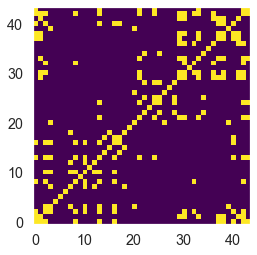

In [29]:
X_rp = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)
plt.imshow(X_rp[0,:], cmap='viridis', origin='lower')
plt.grid(False)

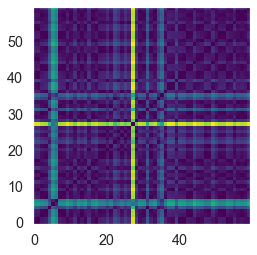

In [31]:
PARAMETROS_RP2 = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
X_rp = RecurrencePlot().set_params(**PARAMETROS_RP2).fit_transform(X)
plt.imshow(X_rp[0,:], cmap='viridis', origin='lower')
plt.grid(False)

In [32]:
X_rp

array([[[0.        , 0.00582504, 0.05967903, ..., 0.0553112 ,
         0.03347778, 0.0363903 ],
        [0.00582504, 0.        , 0.06550407, ..., 0.06113625,
         0.03930283, 0.03056526],
        [0.05967903, 0.06550407, 0.        , ..., 0.00436783,
         0.02620125, 0.09606934],
        ...,
        [0.0553112 , 0.06113625, 0.00436783, ..., 0.        ,
         0.02183342, 0.09170151],
        [0.03347778, 0.03930283, 0.02620125, ..., 0.02183342,
         0.        , 0.06986809],
        [0.0363903 , 0.03056526, 0.09606934, ..., 0.09170151,
         0.06986809, 0.        ]],

       [[0.        , 0.05205345, 0.01862383, ..., 0.4054451 ,
         0.41977167, 0.39064074],
        [0.05205345, 0.        , 0.03342962, ..., 0.45749855,
         0.47182512, 0.44269419],
        [0.01862383, 0.03342962, 0.        , ..., 0.42406893,
         0.4383955 , 0.40926456],
        ...,
        [0.4054451 , 0.45749855, 0.42406893, ..., 0.        ,
         0.01432657, 0.01480436],
        [0.4

In [39]:
X_rp[0,:].min()

0.0